In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# simplified BIOT-like encoder and training script

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os

In [13]:
# Load the dataset
import pickle

file_path = '/content/drive/MyDrive/Colab Notebooks/Purdue Coursework/ECE570_Project/trainval.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

X = data['data']
y = data['labels']

In [14]:
print(X.shape)
print(y.shape)

(480, 23, 1280)
(480,)


In [15]:
# Dataset definition
class CHBMITDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
# Split into train/test
from sklearn.model_selection import train_test_split

# 1. Stratified split using sklearn
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Wrap into PyTorch datasets
train_ds = CHBMITDataset(X_train, y_train)
val_ds = CHBMITDataset(X_val, y_val)

# 3. Then use your existing dataloaders as-is
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [17]:
# Define a simplified version of the BIOT encoder
class SimpleBIOT(nn.Module):
    def __init__(self, input_dim=23, seq_len=1280):
        super().__init__()
        self.conv = nn.Conv1d(input_dim, 64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(64)  # reduce to 64 tokens
        self.token_proj = nn.Linear(64, 64)  # token embedding

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1)
        )

    def forward(self, x):  # x: (B, C, T)
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)  # (B, 64, 64)
        x = x.permute(0, 2, 1)  # (B, seq, feature) = (B, 64, 64)
        x = self.token_proj(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # global average pooling
        return self.classifier(x).squeeze(-1)

In [18]:
# Initialize model
model = SimpleBIOT()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [21]:
from sklearn.metrics import f1_score
train_loss_list, val_acc_list, val_auc_list = [], [], []

for epoch in range(15):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb * 1e5
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb * 1e5
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(yb.numpy())

    pred_labels = [1 if p > 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, pred_labels)
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, pred_labels)
    train_loss_list.append(total_loss / len(train_loader))
    val_acc_list.append(acc)
    val_auc_list.append(auc)

    print(f"Epoch {epoch+1}: loss={train_loss_list[-1]:.4f}, acc={acc:.4f}, AUROC={auc:.4f}, F1={f1:.4f}")

Epoch 1: loss=0.1441, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 2: loss=0.0491, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 3: loss=0.0386, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 4: loss=0.0434, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 5: loss=0.0354, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 6: loss=0.0353, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 7: loss=0.0385, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 8: loss=0.0339, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 9: loss=0.0360, acc=0.9792, AUROC=0.9992, F1=0.9333
Epoch 10: loss=0.0364, acc=0.9792, AUROC=0.9984, F1=0.9333
Epoch 11: loss=0.0381, acc=0.9792, AUROC=0.9984, F1=0.9333
Epoch 12: loss=0.0368, acc=0.9792, AUROC=0.9984, F1=0.9333
Epoch 13: loss=0.0391, acc=0.9792, AUROC=0.9984, F1=0.9333
Epoch 14: loss=0.0331, acc=0.9792, AUROC=0.9984, F1=0.9333
Epoch 15: loss=0.0339, acc=0.9792, AUROC=0.9984, F1=0.9333


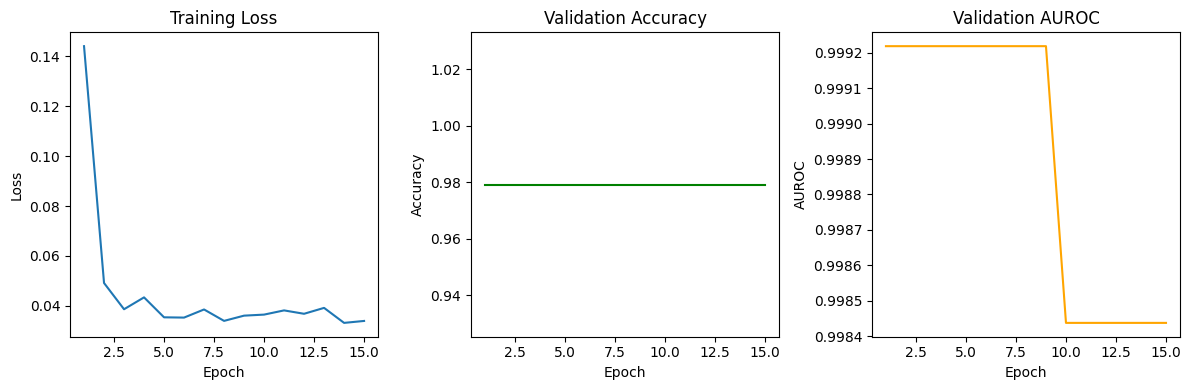

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_acc_list, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")

# AUROC
plt.subplot(1, 3, 3)
plt.plot(epochs, val_auc_list, label="Validation AUROC", color="orange")
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")

plt.tight_layout()
plt.show()


In [23]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Purdue Coursework/ECE570_Project/test.pkl", "rb") as f:
    test_data = pickle.load(f)

X_test = test_data["data"]       # shape: (N, C, T)
y_test = test_data["labels"]     # shape: (N,)


In [24]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_test_tensor = torch.tensor(X_test * 1e5, dtype=torch.float32)  # Scale
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)


In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

model.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

pred_labels = [1 if p > 0.5 else 0 for p in all_probs]

acc = accuracy_score(all_labels, pred_labels)
auc = roc_auc_score(all_labels, all_probs)
f1 = f1_score(all_labels, pred_labels)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUROC:    {auc:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.6833
Test AUROC:    0.7462
Test F1 Score: 0.2400


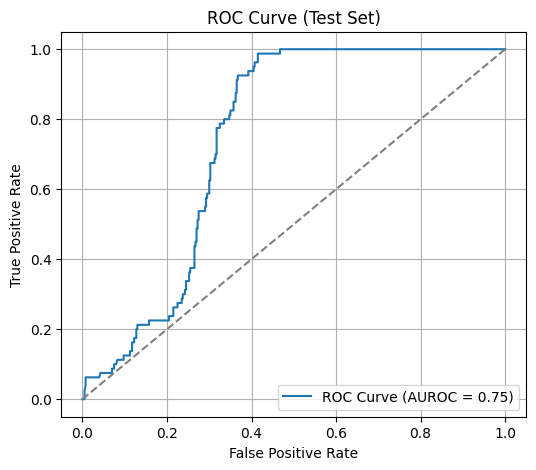

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auroc_value = roc_auc_score(all_labels, all_probs)  # 안전하게 별도 변수에 저장

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc_value:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 500x500 with 0 Axes>

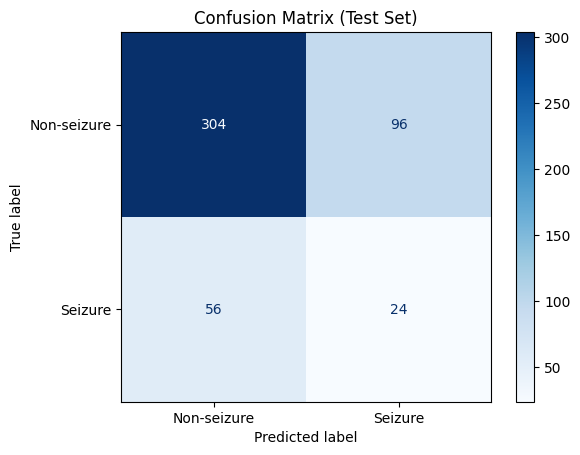

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-seizure", "Seizure"])

plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()


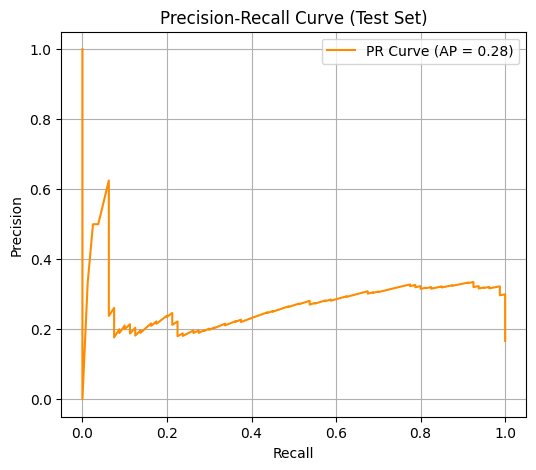

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR Curve (AP = {avg_precision:.2f})", color="darkorange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


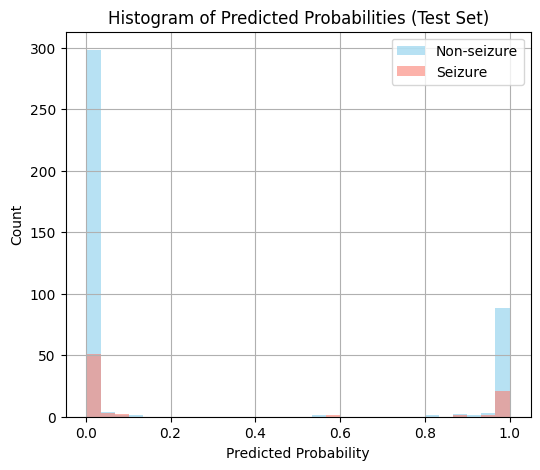

In [32]:
import numpy as np

# Convert to numpy
all_probs_np = np.array(all_probs)
all_labels_np = np.array(all_labels)

plt.figure(figsize=(6, 5))
plt.hist(all_probs_np[all_labels_np == 0], bins=30, alpha=0.6, label="Non-seizure", color="skyblue")
plt.hist(all_probs_np[all_labels_np == 1], bins=30, alpha=0.6, label="Seizure", color="salmon")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Histogram of Predicted Probabilities (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


In [176]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [179]:
from sklearn.metrics import f1_score

# Initialize lists to track training and validation metrics
train_loss_list = []
val_acc_list = []
val_auc_list = []

# Store predictions from the final epoch for analysis
final_probs = []
final_labels = []
final_preds = []

for epoch in range(15):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb * 1e5
        xb, yb = xb.to(device), yb.float().to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    all_probs, all_labels, all_logits = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb * 1e5
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_logits.extend(logits.cpu().numpy())
            all_probs.extend(probs)
            all_labels.extend(yb.numpy())

    print("Logits shape:", np.array(all_logits).shape)
    print("Logits range: min =", np.min(all_logits), ", max =", np.max(all_logits))
    print("First 10 logits:", all_logits[:10])

    # plt.hist(all_logits, bins=50)
    # plt.title("Distribution of Logits Before Sigmoid")
    # plt.xlabel("Logits")
    # plt.ylabel("Count")
    # plt.show()

    # threshold tuning
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_thresh = 0.5
    best_f1 = 0
    for t in thresholds:
        temp_preds = [1 if p > t else 0 for p in all_probs]
        f1 = f1_score(all_labels, temp_preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    print(f"Best threshold = {best_thresh:.2f} (F1 = {best_f1:.2f})")

    # Compute binary predictions from probabilities
    pred_labels = [1 if p > best_thresh else 0 for p in all_probs]

    # Compute evaluation metrics
    acc = accuracy_score(all_labels, pred_labels)
    auc = roc_auc_score(all_labels, all_probs)

    # Save metrics for plotting
    train_loss_list.append(total_loss / len(train_loader))
    val_acc_list.append(acc)
    val_auc_list.append(auc)

    # Save outputs from the final epoch for detailed analysis
    if epoch == 14:
        final_probs = all_probs
        final_labels = all_labels
        final_preds = pred_labels

    print(f"Epoch {epoch+1}: loss={train_loss_list[-1]:.4f}, acc={acc:.4f}, AUROC={auc:.4f}")

Logits shape: (96,)
Logits range: min = -2.5815346 , max = 0.26429632
First 10 logits: [np.float32(-0.06234653), np.float32(-2.5815346), np.float32(-2.575227), np.float32(0.23656063), np.float32(-2.5734959), np.float32(-2.552528), np.float32(-2.5782807), np.float32(-2.5048804), np.float32(-1.8259727), np.float32(-1.7418784)]
Best threshold = 0.25 (F1 = 0.97)
Epoch 1: loss=0.4950, acc=0.9896, AUROC=0.9977
Logits shape: (96,)
Logits range: min = -3.8182588 , max = 0.7324753
First 10 logits: [np.float32(-1.7992337), np.float32(-3.6657767), np.float32(-3.5313346), np.float32(0.7294513), np.float32(-3.703223), np.float32(-3.6040905), np.float32(-3.7816782), np.float32(-3.429337), np.float32(0.488501), np.float32(-0.8064595)]
Best threshold = 0.65 (F1 = 0.94)
Epoch 2: loss=0.3048, acc=0.9792, AUROC=0.9984
Logits shape: (96,)
Logits range: min = -4.196439 , max = 1.6536884
First 10 logits: [np.float32(-3.1500294), np.float32(-3.1202407), np.float32(-3.9800117), np.float32(1.6339023), np.float

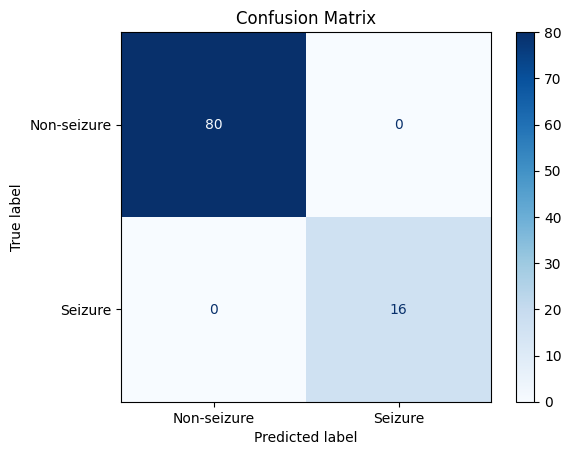

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(final_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-seizure', 'Seizure'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


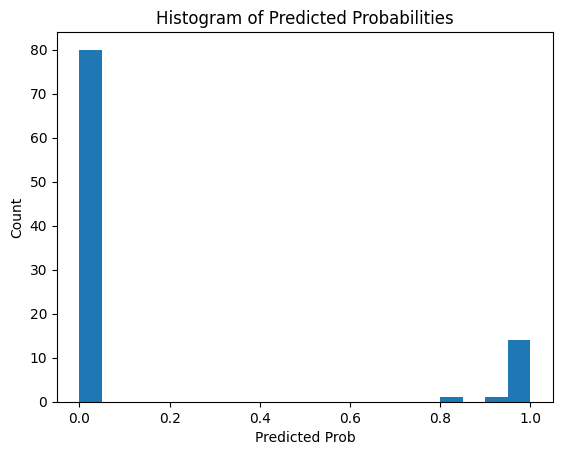

In [181]:
plt.hist(final_probs, bins=20, range=(0, 1))
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Prob")
plt.ylabel("Count")
plt.show()


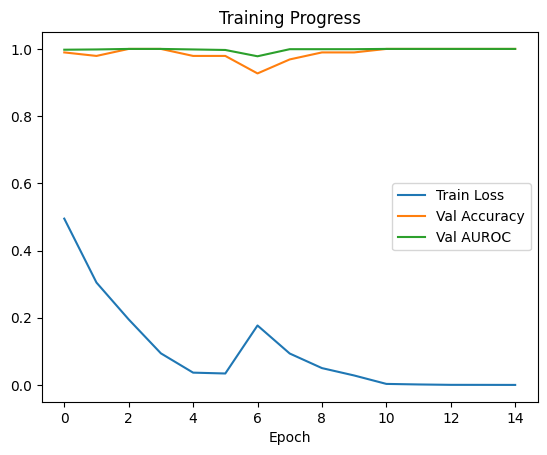

In [182]:
# Plotting
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_acc_list, label="Val Accuracy")
plt.plot(val_auc_list, label="Val AUROC")
plt.legend()
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.show()


In [41]:
# Training loop
train_loss_list = []
val_acc_list = []
val_auc_list = []

for epoch in range(15):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation phase
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.numpy())
            all_labels.extend(yb.numpy())

    pred_labels = [1 if p > 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, pred_labels)
    auc = roc_auc_score(all_labels, all_probs)
    train_loss_list.append(total_loss / len(train_loader))
    val_acc_list.append(acc)
    val_auc_list.append(auc)
    print(f"Epoch {epoch+1}: loss={train_loss_list[-1]:.4f}, acc={acc:.4f}, AUROC={auc:.4f}")

Epoch 1: loss=1.2607, acc=0.1667, AUROC=0.5434
Epoch 2: loss=1.0412, acc=0.8333, AUROC=0.5488
Epoch 3: loss=1.0641, acc=0.8333, AUROC=0.5375
Epoch 4: loss=1.0409, acc=0.8333, AUROC=0.5266
Epoch 5: loss=1.0414, acc=0.1667, AUROC=0.5266
Epoch 6: loss=1.0835, acc=0.1667, AUROC=0.4883
Epoch 7: loss=1.0507, acc=0.8333, AUROC=0.4477
Epoch 8: loss=1.0457, acc=0.1667, AUROC=0.4367
Epoch 9: loss=1.0668, acc=0.1667, AUROC=0.4391
Epoch 10: loss=1.0438, acc=0.8333, AUROC=0.4727
Epoch 11: loss=1.0571, acc=0.1667, AUROC=0.4797
Epoch 12: loss=1.0887, acc=0.1667, AUROC=0.4969
Epoch 13: loss=1.0586, acc=0.8333, AUROC=0.5094
Epoch 14: loss=1.0545, acc=0.8333, AUROC=0.5398
Epoch 15: loss=1.0645, acc=0.8333, AUROC=0.6086


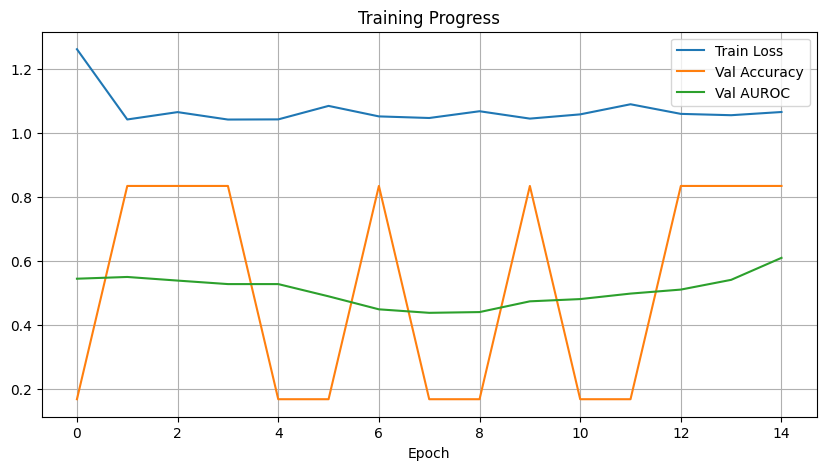

In [42]:
# Visualization of training results
plt.figure(figsize=(10,5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_acc_list, label='Val Accuracy')
plt.plot(val_auc_list, label='Val AUROC')
plt.xlabel("Epoch")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.show()

In [31]:
print("Val seizure count:", sum(y_val), "/", len(y_val))


Val seizure count: 16 / 96


In [32]:
print("Label distribution in total dataset:", np.bincount(y))


Label distribution in total dataset: [400  80]


In [33]:
print("Example probs:", all_probs[:10])


Example probs: [np.float32(0.5028528), np.float32(0.5026814), np.float32(0.50265837), np.float32(0.50277275), np.float32(0.5028606), np.float32(0.502891), np.float32(0.50285006), np.float32(0.50287414), np.float32(0.5028826), np.float32(0.5029141)]
